In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os, sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pandas import DataFrame
import torch, torch.nn as nn
import numpy as np
import random
import networkx as nx
from utils_mcts import *
from MCTS_Act_LSTM import MCTS
from problem_mcts import GraphProblem, generate_erdos_renyi_problems, generate_regular_problems
from network_mcts import AgentActLSTM
import time
import nn_utils
from collections import defaultdict as ddict

In [3]:
sys.path.insert(0, '..')
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [4]:
#params
NUM_PROBLEMS = 15
NUM_EPISODES = 10
BATCH_SIZE = 32
NUM_MCSIMS = 5
NUM_UPDATES = 5
NUM_VERTICES = 15
DEGREE = 6
CPUCT = 10
THRESHOLD = 0.75
PATHS_BUFFER_CAPACITY = 1000
REPLAY_BUFFER_CAPACITY = 5000

In [5]:
#generate regular train graphs (n=15, d=6)
problem_maker = generate_erdos_renyi_problems(num_vertices=NUM_VERTICES, edge_prob=0.3)

In [6]:
#initialize agent
agent = AgentActLSTM(hid_size=256, gcn_size=256, vertex_emb_size=64)

In [7]:
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

In [8]:
#initialize buffers
path_buffer = PathsBuffer(capacity=PATHS_BUFFER_CAPACITY, threshold=THRESHOLD)
train_buffer = ReplayBuffer(capacity=REPLAY_BUFFER_CAPACITY)

In [9]:
# loss stats
pi_losses = []
v_losses = []
rewards = []

In [10]:
problems = [next(problem_maker) for i in range(NUM_PROBLEMS)]

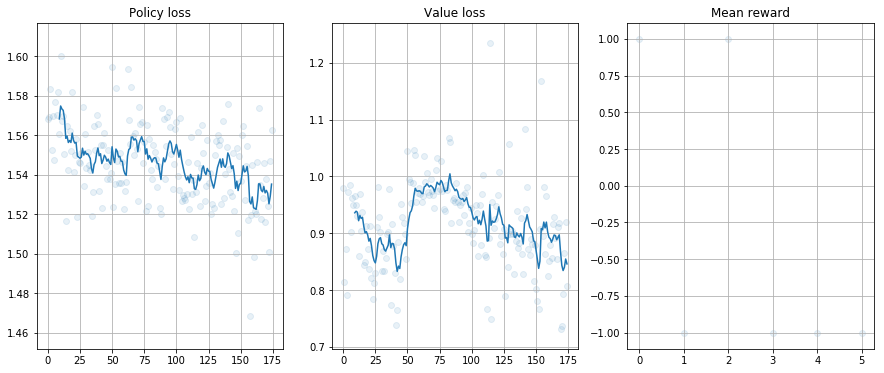

KeyboardInterrupt: 

In [11]:
i = 0

for k in trange(len(problems)):
    
    problem = problems[k]
    
    edges = problem.get_edges()

    for vertex in problem.get_actions():

        path_buffer.flush()
    
        PATH_LENGTH = 2*problem.num_edges + 1        
        
        i += 1
    
        for episode in range(NUM_EPISODES):
            
            problem.path = [vertex]
        
            source = problem.get_state()[0]
            
            states = []
            actions = []
            
            with torch.no_grad():
                graph_emb = agent.embed_graph(problem.edges)
                
            mcts = MCTS(game=problem, nnet=agent, graph_emb=graph_emb,
                        numMCTSSims=NUM_MCSIMS, cpuct=CPUCT, edges=edges, path_length=PATH_LENGTH)
            
            trainExamples = []
                
            random_walk = [source]
            checked = ddict(list)
            stack = [source]
            visited = {source}
            ranks = {0: source} # to attempt to get maximal cover (possible to do without rank, but then no guarantees on maximality)
            revranks = {source: 0}
            
            while len(stack) > 0:
                last = stack[-1]
                lastrank = revranks[last]
                maxrank = max(ranks.keys()) + 1
                with torch.no_grad():
                    pi = mcts.getActionProb(random_walk, path_buffer)
                Nlast = [x for _,x in sorted(zip(pi, edges[random_walk[:][-1]]), reverse=True)]
                #print("Is valid", all(i in edges[random_walk[:][-1]] for i in Nlast))
                # going in depth
                flag = False
                for neighbor in Nlast:
                    if neighbor not in visited:
                        trainExamples.append([random_walk[:], pi, None])
                        random_walk.append(neighbor)
                        stack.append(neighbor)
                        checked[last].append(neighbor)
                        visited.add(neighbor)
                        ranks[maxrank] = neighbor
                        revranks[neighbor] = maxrank
                        flag = True
                        break

                # interconnecting nodes that are already in walk
                if not flag:
                    for r in range(maxrank-1, lastrank+1, -1):
                        node = ranks[r]
                        if node not in checked[last] and node in Nlast:
                            checked[last].append(node)
                            random_walk.extend([node, last])

                if not flag:
                    stack.pop()
                    if len(stack) > 0:
                        random_walk.append(stack[-1])
                        checked[last].append(stack[-1])
                        
            print(check_that_cover(random_walk, problem))
                               
            path_buffer.push(random_walk)
            if len(path_buffer) >= 10: 
                r = path_buffer.rank_path(random_walk)
                rewards.append(r)
                for x in trainExamples:
                    x[-1] = r
                train_buffer.push(trainExamples)
            
            if len(train_buffer) >= BATCH_SIZE:
                print("Start training!")
                for i in range(NUM_UPDATES):
                    batch = train_buffer.sample(BATCH_SIZE)
                    paths, pis, vs = zip(*batch)
                    graph_emb = agent.embed_graph(problem.edges)
                    out_pi, out_v = agent.get_dist(list(paths), graph_emb, edges)

                    target_vs = torch.tensor(vs)

                    losses_pi = []
                    for i, p in enumerate(pis):
                        losses_pi.append(torch.sum(torch.tensor(p)*torch.log(out_pi[i])))

                    loss_pi = -torch.sum(torch.stack(losses_pi))/len(pis)
                    loss_v = torch.sum((target_vs-out_v.view(-1))**2)/target_vs.size()[0]
                    total_loss = loss_pi + loss_v

                    pi_losses.append(loss_pi.item())
                    v_losses.append(loss_v.item())

                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()

                    clear_output(True)
                    plt.figure(figsize=[15, 6])
                    plt.subplot(1,3,1)
                    plt.title('Policy loss'); plt.grid()
                    plt.scatter(np.arange(len(pi_losses)), pi_losses, alpha=0.1)
                    plt.plot(moving_average(pi_losses, span=10, min_periods=10))

                    plt.subplot(1,3,2)
                    plt.title('Value loss'); plt.grid()
                    plt.scatter(np.arange(len(v_losses)), v_losses, alpha=0.1)
                    plt.plot(moving_average(v_losses, span=10, min_periods=10))

                    plt.subplot(1,3,3)
                    plt.title('Mean reward'); plt.grid()
                    plt.scatter(np.arange(len(rewards)), rewards, alpha=0.1)
                    plt.plot(moving_average(rewards, span=10, min_periods=10))
                    plt.show()